In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import matplotlib

from omegaconf import OmegaConf
from hydra.utils import instantiate
import tensorflow as tf
import json

OmegaConf.register_new_resolver("eval", eval)

matplotlib.rcParams["mathtext.fontset"] = "stix"
matplotlib.rcParams["font.family"] = "STIXGeneral"

In [5]:
def hist_ignore_outliers(data, axis, quantile, nbins, **kwargs):

    qlow = np.quantile(data, quantile)
    qhigh = np.quantile(data, 1-quantile)
    axis.hist(data, bins=np.linspace(qlow, qhigh, nbins), **kwargs)

/tmp/ipykernel_16534/1242334682.py:120: MatplotlibDeprecationWarning: The join function was deprecated in Matplotlib 3.6 and will be removed two minor releases later.
  ax[j, 0].get_shared_y_axes().join(*ax[j, 1:])
/tmp/ipykernel_16534/1242334682.py:120: MatplotlibDeprecationWarning: The join function was deprecated in Matplotlib 3.6 and will be removed two minor releases later.
  ax[j, 0].get_shared_y_axes().join(*ax[j, 1:])


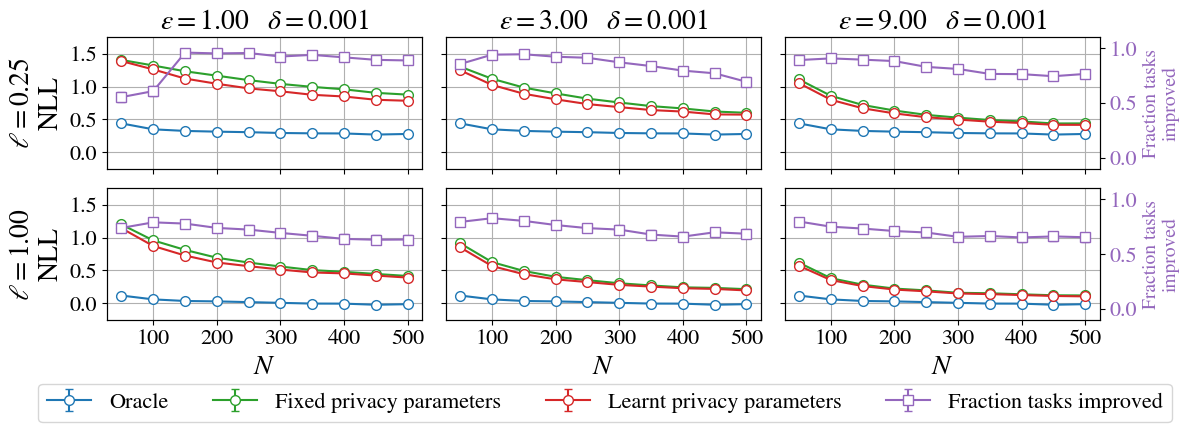

In [3]:
ells = [0.25, 1.00]
num_points = [50, 100, 150, 200, 250, 300, 350, 400, 450, 500,]

# Create 3x3 sub plots
fig, ax = plt.subplots(2, 3, figsize=(12, 4), sharex=True, sharey=True)

for j, ell in enumerate(ells):

    for i, eps in enumerate([1, 3, 9]):

        e = f"{eps:.2f}-{eps:.2f}"
        s = f"{ell:.2f}-{ell:.2f}"

        df_fixed = pd.concat(
            [
                pd.read_csv(
                    f"../_experiments/fixed/eq-{s}_e-{e}_lt-1_dpt-0_dpa-0/eval/p-{p}_ell-{s}_eps-{e}/metrics.csv"
                )
                for p in num_points
            ]
        )
        df_learnt = pd.concat(
            [
                pd.read_csv(
                    f"../_experiments/fixed/eq-{s}_e-{e}_lt-1_dpt-1_dpa-0/eval/p-{p}_ell-{s}_eps-{e}/metrics.csv"
                )
                for p in num_points
            ]
        )

        # Group by n and take mean
        gt_mean_loss = df_fixed.groupby("n").mean()["gt_loss"]
        fixed_mean_loss = df_fixed.groupby("n").mean()["loss"]
        learnt_mean_loss = df_learnt.groupby("n").mean()["loss"]

        # Compute number of rows in each group
        gt_count_loss = df_fixed.groupby("n").count()["gt_loss"]
        fixed_count_loss = df_fixed.groupby("n").count()["loss"]
        learnt_count_loss = df_learnt.groupby("n").count()["loss"]

        # Group by n and take std
        gt_std_loss = df_fixed.groupby("n").std()["gt_loss"] / np.sqrt(gt_count_loss)
        fixed_std_loss = df_fixed.groupby("n").std()["loss"] / np.sqrt(fixed_count_loss)
        learnt_std_loss = df_learnt.groupby("n").std()["loss"] / np.sqrt(learnt_count_loss)

        # Compute fraction of losses where learnt loss is better than fixed loss, grouped by n
        is_better = [
            df_learnt[df_learnt["n"] == i]["loss"] < df_fixed[df_fixed["n"] == i]["loss"]
            for i in num_points
        ]
        is_better_mean = np.array([np.mean(x) for x in is_better])
        is_better_std = np.array([np.std(x) / np.sqrt(len(x)) for x in is_better])

        ax[j, i].errorbar(
            gt_mean_loss.index,
            gt_mean_loss.values,
            yerr=2*gt_std_loss.values,
            linestyle="-",
            marker="o",
            color="tab:blue",
            linewidth=1.5,
            markersize=7,
            markerfacecolor="white",
            capsize=3,
            **({"label": "Oracle"} if i == j == 0 else {}),
        )
        ax[j, i].errorbar(
            fixed_mean_loss.index,
            fixed_mean_loss.values,
            yerr=2*fixed_std_loss.values,
            linestyle="-",
            marker="o",
            color="tab:green",
            linewidth=1.5,
            markersize=7,
            markerfacecolor="white",
            capsize=3,
            **({"label": "Fixed privacy parameters"} if i == j == 0 else {}),
        )
        ax[j, i].errorbar(
            learnt_mean_loss.index,
            learnt_mean_loss.values,
            yerr=2*learnt_std_loss.values,
            linestyle="-",
            marker="o",
            color="tab:red",
            linewidth=1.5,
            markersize=7,
            markerfacecolor="white",
            capsize=3,
            **({"label": "Learnt privacy parameters"} if i == j == 0 else {}),
        )
        ax[j, i].grid("on")

        ax[j, i].set_ylim([-0.25, 1.75])
        ax[j, i].set_xticks(np.arange(0, 600, 100), np.arange(0, 600, 100), fontsize=16)
        ax[j, i].set_yticks(np.arange(0, 1.75, 0.5), np.arange(0, 1.75, 0.5), fontsize=16)

        ax2 = ax[j, i].twinx()
        ax2.errorbar(
            num_points,
            is_better_mean,
            yerr=2*is_better_std,
            marker="s",
            color="tab:purple",
            markersize=7,
            markerfacecolor="white",
            capsize=3,
            **({"label": "Fraction tasks improved"} if i == 2 and j == 1 else {}),
        )
        ax2.set_yticks(np.arange(0., 1.05, 0.50), np.arange(0.0, 1.05, 0.50), fontsize=16, color="tab:purple")
        ax2.set_ylim([-0.1, 1.1])

        if i == 2:
            ax2.set_ylabel(f"Fraction tasks\nimproved", fontsize=14, color="tab:purple")

        else:
            ax2.set_yticks([], [], fontsize=14)

    ax[j, 0].get_shared_y_axes().join(*ax[j, 1:])

for i, eps in enumerate([1, 3, 9]):
    ax[0, i].set_title(f"$\\epsilon = {eps:.2f}~~~\\delta = 0.001$", fontsize=20)
    ax[1, i].set_xlabel("$N$", fontsize=20)

for i, ell in enumerate(ells):
    ax[i, 0].set_ylabel(f"$\\ell = {ell:.2f}$\nNLL", fontsize=20)

handles, labels = ax[0, 0].get_legend_handles_labels()
handles_prob, labels_prob = plt.gca().get_legend_handles_labels()
handles.extend(handles_prob)
labels.extend(labels_prob)
fig.legend(handles, labels, loc="center right", bbox_to_anchor=(0.99, -0.02), fontsize=16, ncol=4)

plt.tight_layout()
plt.savefig("fig/fixed-vs-learnt.pdf", bbox_inches="tight")
plt.show()

/tmp/ipykernel_16534/4013228589.py:90: MatplotlibDeprecationWarning: The join function was deprecated in Matplotlib 3.6 and will be removed two minor releases later.
  ax[j, 0].get_shared_y_axes().join(*ax[j, 1:])
/tmp/ipykernel_16534/4013228589.py:90: MatplotlibDeprecationWarning: The join function was deprecated in Matplotlib 3.6 and will be removed two minor releases later.
  ax[j, 0].get_shared_y_axes().join(*ax[j, 1:])


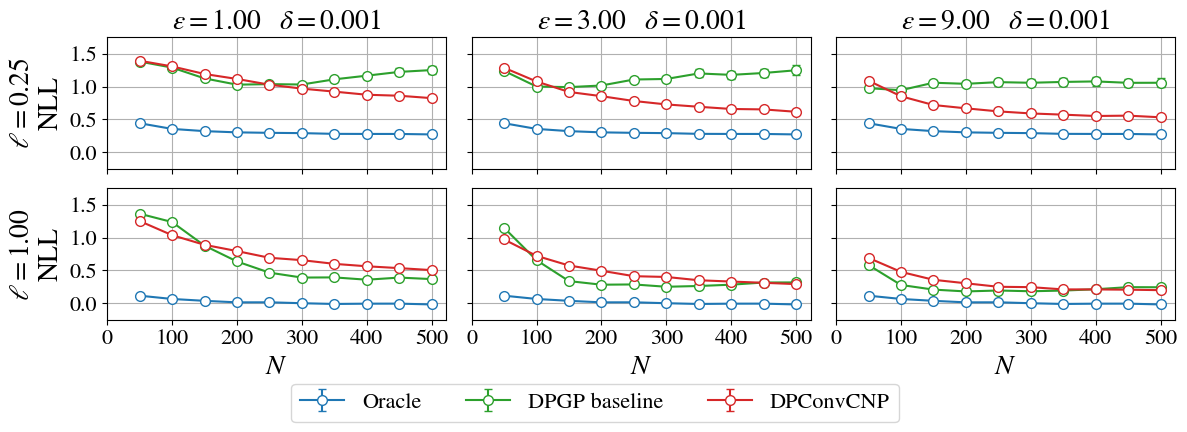

In [18]:
ells = [0.25, 1.00]
num_points = [50, 100, 150, 200, 250, 300, 350, 400, 450, 500,]

dpgp = json.load(open("synthetic_results.json", "r"))
dpgp["1.00"] = dpgp["1.0"]

# Create 3x3 sub plots
fig, ax = plt.subplots(2, 3, figsize=(12, 4), sharex=True, sharey=True)

for j, ell in enumerate(ells):

    for i, eps in enumerate([1, 3, 9]):

        e = f"{eps:.2f}-{eps:.2f}"
        s = f"{ell:.2f}-{ell:.2f}"

        df_learnt = pd.concat(
            [
                pd.read_csv(
                    f"../_experiments/variable/eq-0.20-5.00_e-0.90-10.00_lt-1_dpt-1_dpa-1/"
                    #f"../_experiments/_20_09_run/eq-0.20-2.50_e-{eps:.2f}-{eps:.2f}_lt-1_dpt-1_dpa-0/"
                    f"eval/p-{p}_ell-{s}_eps-{e}/metrics.csv"
                )
                for p in num_points
            ]
        )

        data = dpgp[f"{ell:.2f}"][f"{eps:.1f}"]

        # Group by n and take mean
        gt_mean_loss = df_learnt.groupby("n").mean()["gt_loss"]
        learnt_mean_loss = df_learnt.groupby("n").mean()["loss"]

        # Compute number of rows in each group
        gt_count_loss = df_learnt.groupby("n").count()["gt_loss"]
        learnt_count_loss = df_learnt.groupby("n").count()["loss"]

        # Group by n and take std
        gt_std_loss = df_learnt.groupby("n").std()["gt_loss"] / np.sqrt(gt_count_loss)
        learnt_std_loss = df_learnt.groupby("n").std()["loss"] / np.sqrt(learnt_count_loss)

        gp_mean_loss = np.array([data[str(n)]["mean_nll"] for n in num_points])
        gp_std_loss = np.array([data[str(n)]["ste_nll"] for n in num_points])

        ax[j, i].errorbar(
            gt_mean_loss.index,
            gt_mean_loss.values,
            yerr=2*gt_std_loss.values,
            linestyle="-",
            marker="o",
            color="tab:blue",
            linewidth=1.5,
            markersize=7,
            markerfacecolor="white",
            capsize=3,
            **({"label": "Oracle"} if i == j == 0 else {}),
        )
        ax[j, i].errorbar(
            num_points,
            gp_mean_loss,
            yerr=2*gp_std_loss,
            linestyle="-",
            marker="o",
            color="tab:green",
            linewidth=1.5,
            markersize=7,
            markerfacecolor="white",
            capsize=3,
            **({"label": "DPGP baseline"} if i == j == 0 else {}),
        )
        ax[j, i].errorbar(
            learnt_mean_loss.index,
            learnt_mean_loss.values,
            yerr=2*learnt_std_loss.values,
            linestyle="-",
            marker="o",
            color="tab:red",
            linewidth=1.5,
            markersize=7,
            markerfacecolor="white",
            capsize=3,
            **({"label": "DPConvCNP"} if i == j == 0 else {}),
        )
        ax[j, i].grid("on")

        ax[j, i].set_ylim([-0.25, 1.75])
        ax[j, i].set_xticks(np.arange(0, 600, 100), np.arange(0, 600, 100), fontsize=16)
        ax[j, i].set_yticks(np.arange(0, 1.75, 0.5), np.arange(0, 1.75, 0.5), fontsize=16)

    ax[j, 0].get_shared_y_axes().join(*ax[j, 1:])

for i, eps in enumerate([1, 3, 9]):
    ax[0, i].set_title(f"$\\epsilon = {eps:.2f}~~~\\delta = 0.001$", fontsize=20)
    ax[1, i].set_xlabel("$N$", fontsize=20)

for i, ell in enumerate(ells):
    ax[i, 0].set_ylabel(f"$\\ell = {ell:.2f}$\nNLL", fontsize=20)

handles, labels = ax[0, 0].get_legend_handles_labels()
handles_prob, labels_prob = plt.gca().get_legend_handles_labels()
handles.extend(handles_prob)
labels.extend(labels_prob)
fig.legend(handles, labels, loc="center", bbox_to_anchor=(0.5, -0.02), fontsize=16, ncol=4)

plt.tight_layout()
plt.savefig("fig/toy-results.pdf", bbox_inches="tight")
plt.show()

/tmp/ipykernel_13117/1324893621.py:92: MatplotlibDeprecationWarning: The join function was deprecated in Matplotlib 3.6 and will be removed two minor releases later.
  ax[j, 0].get_shared_y_axes().join(*ax[j, 1:])
/tmp/ipykernel_13117/1324893621.py:92: MatplotlibDeprecationWarning: The join function was deprecated in Matplotlib 3.6 and will be removed two minor releases later.
  ax[j, 0].get_shared_y_axes().join(*ax[j, 1:])


/tmp/ipykernel_13117/1324893621.py:92: MatplotlibDeprecationWarning: The join function was deprecated in Matplotlib 3.6 and will be removed two minor releases later.
  ax[j, 0].get_shared_y_axes().join(*ax[j, 1:])


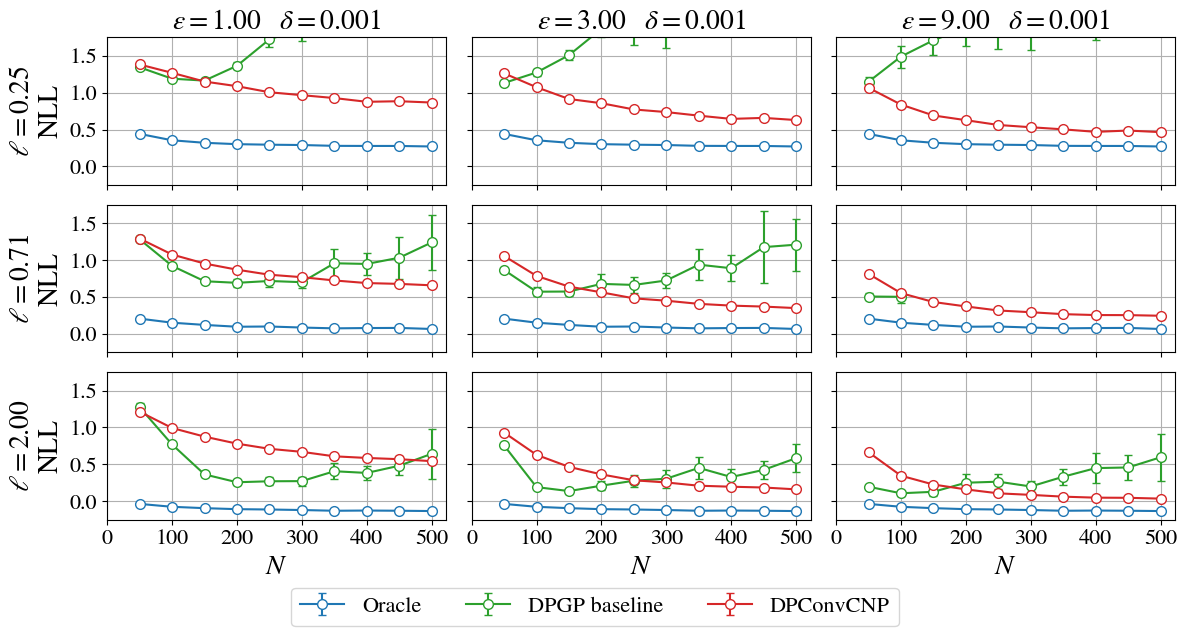

In [22]:
ells = [0.25, 0.71, 2.00]
num_points = [50, 100, 150, 200, 250, 300, 350, 400, 450, 500]

dpgp = json.load(open("synthetic_results_new.json", "r"))
dpgp["2.00"] = dpgp["2.0"]
dpgp["0.71"] = dpgp["0.707"]

# Create 3x3 sub plots
fig, ax = plt.subplots(3, 3, figsize=(12, 6), sharex=True, sharey=True)

for j, ell in enumerate(ells):

    for i, eps in enumerate([1, 3, 9]):

        e = f"{eps:.2f}-{eps:.2f}"
        s = f"{ell:.2f}-{ell:.2f}"

        df_learnt = pd.concat(
            [
                pd.read_csv(
                    f"../_experiments/_20_09_run/eq-0.20-2.50_e-{eps:.2f}-{eps:.2f}_lt-1_dpt-1_dpa-0/"
                    #f"../_experiments/_21_09_run/eq-0.20-2.50_e-{eps:.2f}-{eps:.2f}_lt-1_dpt-1_dpa-1/"
                    #f"../_experiments/_21_09_run/eq-0.20-2.50_e-0.90-10.00_lt-1_dpt-1_dpa-1/"
                    f"eval/p-{p}_ell-{s}_eps-{e}/metrics.csv"
                )
                for p in num_points
            ]
        )

        # Group by n and take mean
        gt_mean_loss = df_learnt.groupby("n").mean()["gt_loss"]
        learnt_mean_loss = df_learnt.groupby("n").mean()["loss"]

        # Compute number of rows in each group
        gt_count_loss = df_learnt.groupby("n").count()["gt_loss"]
        learnt_count_loss = df_learnt.groupby("n").count()["loss"]

        # Group by n and take std
        gt_std_loss = df_learnt.groupby("n").std()["gt_loss"] / np.sqrt(gt_count_loss)
        learnt_std_loss = df_learnt.groupby("n").std()["loss"] / np.sqrt(learnt_count_loss)

        data = dpgp[f"{ell:.2f}"][f"{eps:.1f}"]

        gp_mean_loss = np.array([data[str(n)]["mean_nll"] if str(n) in data else float('nan') for n in num_points])
        gp_std_loss = np.array([data[str(n)]["ste_nll"] if str(n) in data else float('nan') for n in num_points])

        ax[j, i].errorbar(
            gt_mean_loss.index,
            gt_mean_loss.values,
            yerr=2*gt_std_loss.values,
            linestyle="-",
            marker="o",
            color="tab:blue",
            linewidth=1.5,
            markersize=7,
            markerfacecolor="white",
            capsize=3,
            **({"label": "Oracle"} if i == j == 0 else {}),
        )
        ax[j, i].errorbar(
            num_points,
            gp_mean_loss,
            yerr=2*gp_std_loss,
            linestyle="-",
            marker="o",
            color="tab:green",
            linewidth=1.5,
            markersize=7,
            markerfacecolor="white",
            capsize=3,
            **({"label": "DPGP baseline"} if i == j == 0 else {}),
        )
        ax[j, i].errorbar(
            learnt_mean_loss.index,
            learnt_mean_loss.values,
            yerr=2*learnt_std_loss.values,
            linestyle="-",
            marker="o",
            color="tab:red",
            linewidth=1.5,
            markersize=7,
            markerfacecolor="white",
            capsize=3,
            **({"label": "DPConvCNP"} if i == j == 0 else {}),
        )
        ax[j, i].grid("on")

        ax[j, i].set_ylim([-0.25, 1.75])
        ax[j, i].set_xticks(np.arange(0, 600, 100), np.arange(0, 600, 100), fontsize=16)
        ax[j, i].set_yticks(np.arange(0, 1.75, 0.5), np.arange(0, 1.75, 0.5), fontsize=16)

    ax[j, 0].get_shared_y_axes().join(*ax[j, 1:])

for i, eps in enumerate([1, 3, 9]):
    ax[0, i].set_title(f"$\\epsilon = {eps:.2f}~~~\\delta = 0.001$", fontsize=20)
    ax[2, i].set_xlabel("$N$", fontsize=20)

for i, ell in enumerate(ells):
    ax[i, 0].set_ylabel(f"$\\ell = {ell:.2f}$\nNLL", fontsize=20)

handles, labels = ax[0, 0].get_legend_handles_labels()
handles_prob, labels_prob = plt.gca().get_legend_handles_labels()
handles.extend(handles_prob)
labels.extend(labels_prob)
fig.legend(handles, labels, loc="center", bbox_to_anchor=(0.5, -0.02), fontsize=16, ncol=4)

plt.tight_layout()
plt.savefig("fig/toy-results-new.pdf", bbox_inches="tight")
plt.show()

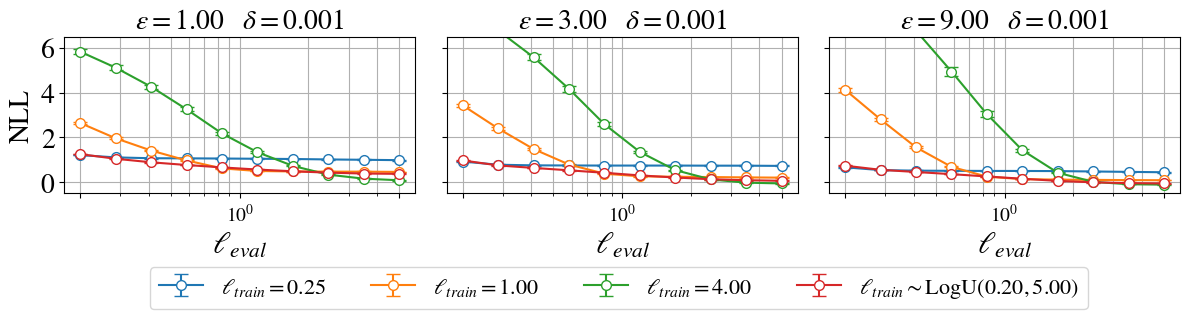

In [169]:
fig = plt.figure(figsize=(12, 2.8))

for i, eps in enumerate(["1.00-1.00", "3.00-3.00", "9.00-9.00"]):

    ells = ["0.25-0.25", "1.00-1.00", "4.00-4.00", "0.20-5.00"]
    colors = ["tab:blue", "tab:orange", "tab:green", "tab:red"]
    names = ["$\\ell_{train} = 0.25$", "$\\ell_{train} = 1.00$", "$\\ell_{train} = 4.00$", "$\\ell_{train} \\sim $LogU$(0.20, 5.00)$"]

    results = {}
    lengthscales = np.linspace(np.log10(0.2), np.log10(5), 10)

    for ell in ells:
        results[ell] = []
        results[f"{ell}_mean"] = []
        results[f"{ell}_std"] = []

        for eval_ell in lengthscales:

            df = pd.read_csv(
                f"../_experiments/eq-{ell}_e-{eps}_lt-1_dpt-1_dpa-0/eval/ell-{eval_ell:.2f}-{eval_ell:.2f}_eps-{eps}/metrics.csv"
            )

            # Keep examples with n > N
            df = df[df["n"] > 0]

            results[f"{ell}_mean"].append(df["loss"].median())
            results[f"{ell}_std"].append(df["loss"].std() / np.sqrt(len(df["loss"])))


        results[f"{ell}_mean"] = np.stack(results[f"{ell}_mean"])
        results[f"{ell}_std"] = np.stack(results[f"{ell}_std"])


    plt.subplot(1, 3, i+1)

    for ell, c, name in zip(ells, colors, names):
        plt.errorbar(
            10 ** lengthscales,
            results[f"{ell}_mean"],
            2.0 * results[f"{ell}_std"],
            color=c,
            capsize=5,
            marker="o",
            markerfacecolor="white",
            label=name,
            markersize=7,
        )
        
    plt.title(f"$\\epsilon = {eps[:4]}~~~\\delta = 0.001$", fontsize=20)

    plt.ylim([-0.5, 6.5])
    plt.xscale("log")
    
    if i == 0:
        plt.ylabel("NLL", fontsize=20)
        plt.yticks([0, 2, 4, 6], fontsize=20)

    else:
        plt.yticks(color="white")

    plt.xticks([0.2, 1.0, 5.0], fontsize=14)
    
    plt.xlabel("$\\ell_{eval}$", fontsize=22)

    plt.grid(which="both")
    plt.tick_params(axis="x", which="both")
    

handles, labels = plt.gca().get_legend_handles_labels()
fig.legend(handles, labels, loc="center right", fontsize=16, bbox_to_anchor=(0.92, -0.05), ncol=4)

plt.tight_layout()
plt.savefig("fig/variable_lengthscale.pdf", bbox_inches="tight")
plt.show()

1.00-1.00 0
3.00-3.00 0
9.00-9.00 0
0.90-10.00 0
0.90-10.00 1
1.00-1.00 0
3.00-3.00 0
9.00-9.00 0
0.90-10.00 0
0.90-10.00 1
1.00-1.00 0
3.00-3.00 0
9.00-9.00 0
0.90-10.00 0
0.90-10.00 1


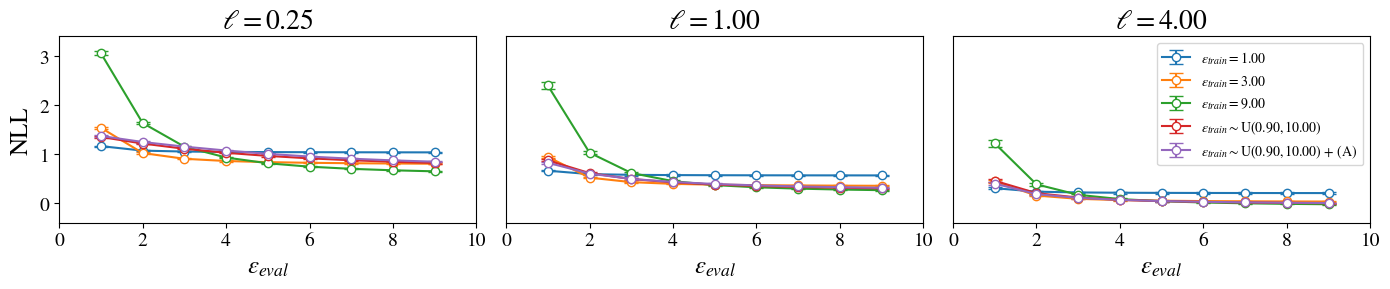

In [4]:
plt.figure(figsize=(14, 3))

for i, ell in enumerate(["0.25-0.25", "1.00-1.00", "4.00-4.00"]):

    train_epsilons = ["1.00-1.00", "3.00-3.00", "9.00-9.00", "0.90-10.00", "0.90-10.00"]
    eval_epsilons = np.linspace(1.0, 9.0, 9)

    colors = ["tab:blue", "tab:orange", "tab:green", "tab:red", "tab:purple"]
    names = [
        "$\\epsilon_{train} = 1.00$",
        "$\\epsilon_{train} = 3.00$",
        "$\\epsilon_{train} = 9.00$",
        "$\\epsilon_{train} \\sim $U$(0.90, 10.00)$",
        "$\\epsilon_{train} \\sim $U$(0.90, 10.00)$ + (A)",
    ]

    amort = [0, 0, 0, 0, 1]

    results = {}

    for a, te in zip(amort, train_epsilons):
        results[f"{te}_{a}"] = []
        results[f"{te}_{a}_mean"] = []
        results[f"{te}_{a}_std"] = []

        for ee in eval_epsilons:

            df = pd.read_csv(
                f"../_experiments/eq-{ell}_e-{te}_lt-1_dpt-1_dpa-{a}/eval/ell-{ell}_eps-{ee:.2f}-{ee:.2f}/metrics.csv"
            )

            # Keep examples with n > N
            df = df[df["n"] > 0]

            results[f"{te}_{a}_mean"].append(df["loss"].mean())
            results[f"{te}_{a}_std"].append(df["loss"].std() / np.sqrt(len(df["loss"])))


        results[f"{te}_{a}_mean"] = np.stack(results[f"{te}_{a}_mean"])
        results[f"{te}_{a}_std"] = np.stack(results[f"{te}_{a}_std"])


    plt.subplot(1, 3, i+1)

    for te, a, c, name in zip(train_epsilons, amort, colors, names):
        print(te, a)
        plt.errorbar(
            eval_epsilons,
            results[f"{te}_{a}_mean"],
            2.0 * results[f"{te}_{a}_std"],
            color=c,
            capsize=5,
            marker="o",
            markerfacecolor="white",
            label=name,
        )
        
    plt.title(f"$\\ell = {ell[:4]}$", fontsize=20)

    if i == 2:
        plt.legend()
    
    if i == 0:
        plt.ylabel("NLL", fontsize=18)
        plt.yticks(np.linspace(0, 3, 4), fontsize=14)

    else:
        plt.yticks([])

    plt.ylim([-0.4, 3.4])
    plt.xticks(np.arange(0, 11, 2), fontsize=14)
    
    plt.xlabel("$\\epsilon_{eval}$", fontsize=18)

plt.tight_layout()
plt.savefig("fig/variable_epsilon.pdf")
plt.show()


In [5]:
class ModelCheckpointer:
    def __init__(self, path: str):
        self.path = path
        self.best_validation_loss = float("inf")

    def update_best_and_last_checkpoints(
        self,
        model,
        valid_result,
    ) -> None:
        """Update the best and last checkpoints of the model.

        Arguments:
            model: model to save.
            valid_result: validation result dictionary.
        """

        if valid_result["loss"] < self.best_validation_loss:
            self.best_validation_loss = valid_result["loss"]
            model.save_weights(f"{self.path}/best")

        model.save_weights(f"{self.path}/last")

    def load_best_checkpoint(self, model) -> None:
        model.load_weights(f"{self.path}/best")

    def load_last_checkpoint(self, model) -> None:
        model.load_weights(f"{self.path}/last")

def initialize_evaluation(
    experiment_path,
):

    # Initialize experiment, make path and writer
    experiment_config = OmegaConf.load(f"{experiment_path}/config.yml")
    experiment = instantiate(experiment_config)

    # Create model checkpointer and load model
    checkpointer = ModelCheckpointer(
        path=f"{experiment_path}/checkpoints",
    )

    # Set model
    model = experiment.model

    # Load model weights
    checkpointer.load_last_checkpoint(model=model)

    return model

In [5]:
y_bounds = []
w_noise = []

for e in ["1.00-1.00", "3.00-3.00", "9.00-9.00"]:

    m = initialize_evaluation(
        experiment_path=f"../_experiments/_debug_large/es-0.15_eq-0.20-2.50_e-0.90-10.0_lt-0_dpt-1_dpa-1" # f"../_experiments/_21_09_run/eq-0.71-0.71_e-{e}_lt-1_dpt-1_dpa-0",
    )

    y_bounds.append(m.dpsetconv_encoder.y_bound(None))
    w_noise.append(m.dpsetconv_encoder.w_noise(None))

mf = initialize_evaluation(
    experiment_path="../_experiments/_21_09_run/eq-0.71-0.71_e-0.90-10.00_lt-1_dpt-1_dpa-0",
)

ma = initialize_evaluation(
    experiment_path="../_experiments/_21_09_run/eq-0.71-0.71_e-0.90-10.00_lt-1_dpt-1_dpa-1",
)

2023-09-22 13:18:11.866100: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1635] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 9591 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 2080 Ti, pci bus id: 0000:17:00.0, compute capability: 7.5
2023-09-22 13:18:11.866569: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1635] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 9039 MB memory:  -> device: 1, name: NVIDIA GeForce RTX 2080 Ti, pci bus id: 0000:b3:00.0, compute capability: 7.5


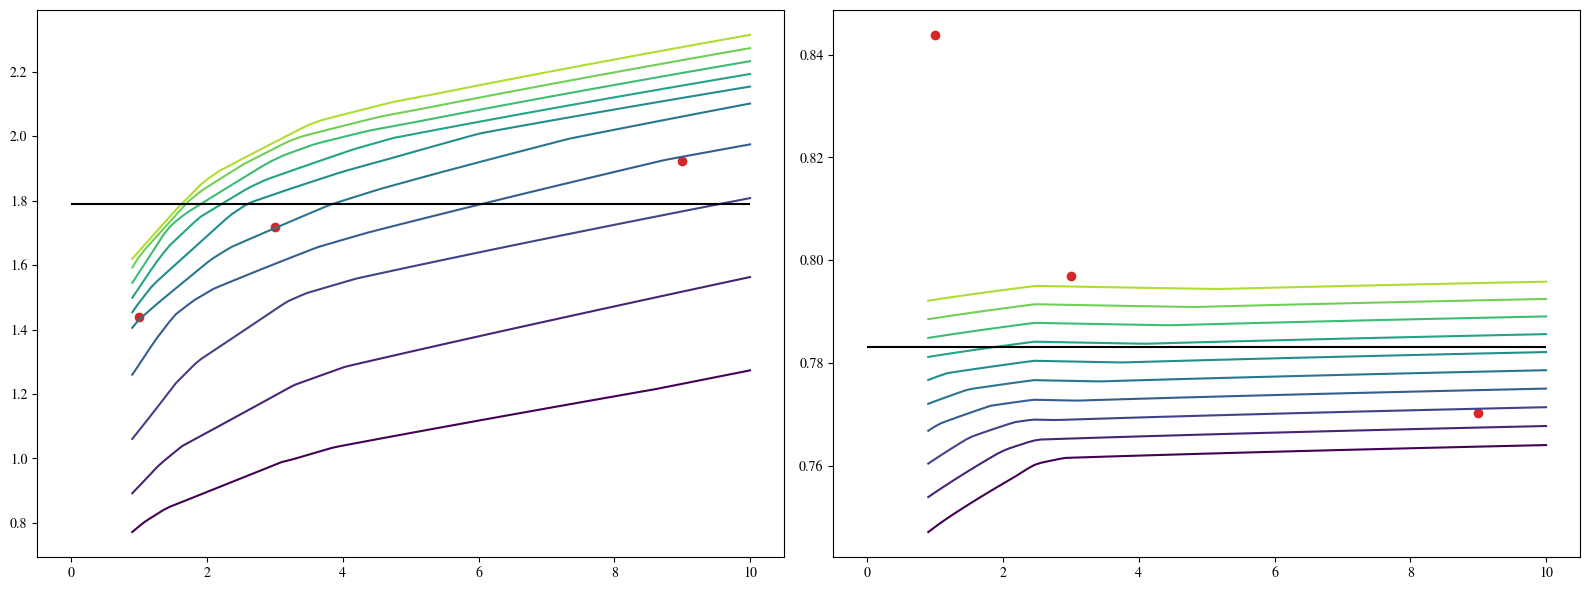

In [88]:
from dpconvcnp.model.privacy_accounting import sens_per_sigma

colormap = plt.get_cmap('viridis')

plt.figure(figsize=(16, 6))
for N in np.arange(1, 501, 50):
    epsilons = tf.linspace(0.9, 10.0, 100)
    deltas = tf.ones_like(epsilons) * 0.001
    num_ctx = tf.ones_like(epsilons) * N
    sens = sens_per_sigma(epsilons, deltas)
    sens_num_ctx = tf.stack([sens, num_ctx / 512.], axis=-1)

    amort_y_bound = ma.dpsetconv_encoder.y_bound(sens_num_ctx)
    amort_w = ma.dpsetconv_encoder.w_noise(sens_num_ctx)

    fixed_y_bound = mf.dpsetconv_encoder.y_bound(sens_num_ctx)[0, 0]
    fixed_w = mf.dpsetconv_encoder.w_noise(sens_num_ctx)[0, 0]

    plt.subplot(1, 2, 1)
    plt.plot(epsilons, amort_y_bound, color=colormap(N/512.))
    
    plt.subplot(1, 2, 2)
    plt.plot(epsilons, amort_w, color=colormap(N/512.))

plt.subplot(1, 2, 1)
plt.hlines(fixed_y_bound, 0, 10, color="black")
plt.scatter([1, 3, 9], y_bounds, color="tab:red")

plt.subplot(1, 2, 2)
plt.hlines(fixed_w, 0, 10, color="black")
plt.scatter([1, 3, 9], w_noise, color="tab:red")

plt.tight_layout()
plt.savefig("fig/amort.pdf")
plt.show()

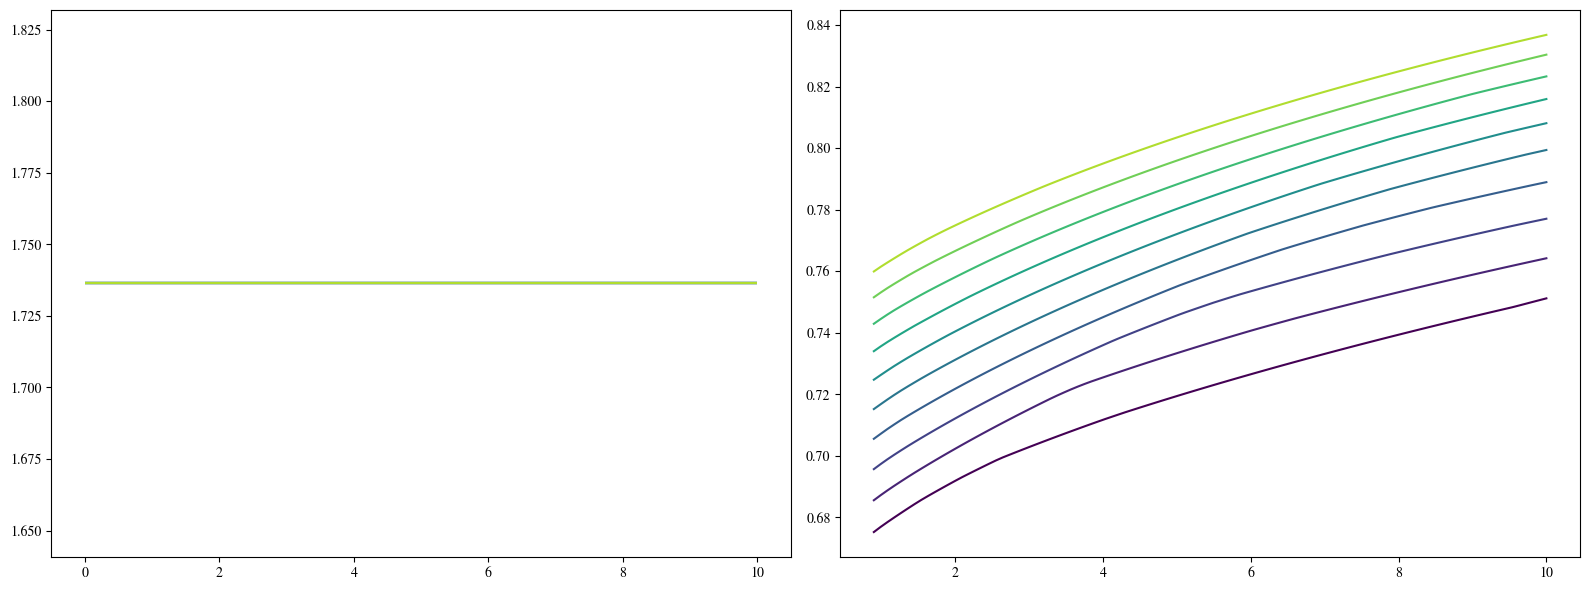

In [12]:
from dpconvcnp.model.privacy_accounting import sens_per_sigma

ma = initialize_evaluation(
    experiment_path="../_experiments/_amort_test/eq-0.71-0.71_e-0.90-10.00_lt-1_dpt-1_dpa-1",
)

colormap = plt.get_cmap('viridis')

plt.figure(figsize=(16, 6))
for N in np.arange(1, 501, 50):
    epsilons = tf.linspace(0.9, 10.0, 100)
    deltas = tf.ones_like(epsilons) * 0.001
    num_ctx = tf.ones_like(epsilons) * N
    sens = sens_per_sigma(epsilons, deltas)
    sens_num_ctx = tf.stack([sens, num_ctx / 512.], axis=-1)

    amort_y_bound = ma.dpsetconv_encoder.y_bound(sens_num_ctx)
    amort_w = ma.dpsetconv_encoder.w_noise(sens_num_ctx)

    plt.subplot(1, 2, 1)
    plt.hlines(amort_y_bound[0, 0], 0, 10, color=colormap(N/512.))
    
    plt.subplot(1, 2, 2)
    plt.plot(epsilons, amort_w[:, 0], color=colormap(N/512.))

plt.tight_layout()
plt.show()

In [ ]:
from dpconvcnp.model.privacy_accounting import sens_per_sigma

ma = initialize_evaluation(
    experiment_path="../_experiments/_amort_test_inv/eq-0.71-0.71_e-0.90-10.00_lt-1_dpt-1_dpa-1",
)

colormap = plt.get_cmap('viridis')

plt.figure(figsize=(16, 6))
for N in np.arange(1, 501, 50):
    epsilons = tf.linspace(0.9, 10.0, 100)
    deltas = tf.ones_like(epsilons) * 0.001
    num_ctx = tf.ones_like(epsilons) * N
    sens = sens_per_sigma(epsilons, deltas)
    sens_num_ctx = tf.stack([sens, num_ctx / 512.], axis=-1)

    amort_y_bound = ma.dpsetconv_encoder.y_bound(sens_num_ctx)
    amort_w = ma.dpsetconv_encoder.w_noise(sens_num_ctx)

    plt.subplot(1, 2, 1)
    plt.hlines(amort_y_bound[0, 0], 0, 10, color=colormap(N/512.))
    
    plt.subplot(1, 2, 2)
    plt.plot(epsilons, amort_w[:, 0], color=colormap(N/512.))

plt.tight_layout()
plt.show()

In [25]:
sens_per_sigma(epsilons, deltas)

<tf.Tensor: shape=(100,), dtype=float32, numpy=
array([0.3555271 , 0.38576648, 0.41552404, 0.44483787, 0.47373986,
       0.5022573 , 0.5304142 , 0.55823106, 0.5857264 , 0.61291593,
       0.63981485, 0.6664361 , 0.69279164, 0.71889246, 0.7447489 ,
       0.7703694 , 0.7957632 , 0.8209381 , 0.84590113, 0.8706595 ,
       0.8952193 , 0.91958666, 0.94376737, 0.96776664, 0.99159   ,
       1.0152414 , 1.0387259 , 1.0620475 , 1.0852107 , 1.1082188 ,
       1.1310759 , 1.1537855 , 1.1763507 , 1.1987747 , 1.2210613 ,
       1.2432126 , 1.2652318 , 1.2871219 , 1.308885  , 1.3305238 ,
       1.352041  , 1.3734385 , 1.3947189 , 1.4158841 , 1.4369364 ,
       1.4578779 , 1.4787104 , 1.499436  , 1.5200564 , 1.5405731 ,
       1.5609883 , 1.5813032 , 1.6015201 , 1.6216396 , 1.6416643 ,
       1.661595  , 1.6814332 , 1.7011808 , 1.7208387 , 1.7404078 ,
       1.7598903 , 1.7792872 , 1.7985994 , 1.8178283 , 1.8369751 ,
       1.8560411 , 1.8750272 , 1.8939341 , 1.9127635 , 1.9315164 ,
       1.95019

In [7]:
ma = initialize_evaluation(
    experiment_path="../_experiments/_debug_large/es-0.15_eq-0.20-2.50_e-0.90-10.00_lt-0_dpt-1_dpa-1",
)

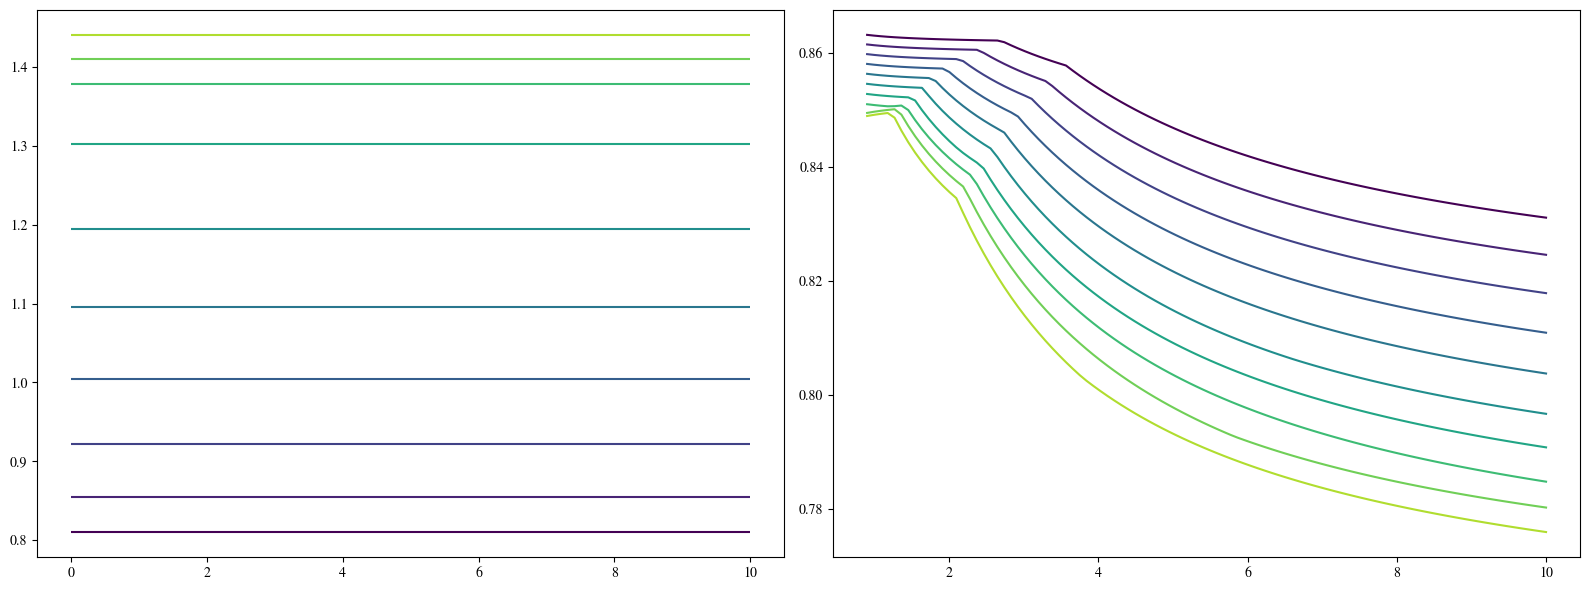

In [8]:
from dpconvcnp.model.privacy_accounting import sens_per_sigma

colormap = plt.get_cmap('viridis')

plt.figure(figsize=(16, 6))
for N in np.arange(1, 501, 50):
    epsilons = tf.linspace(0.9, 10.0, 100)
    deltas = tf.ones_like(epsilons) * 0.001
    num_ctx = tf.ones_like(epsilons) * N
    sens = sens_per_sigma(epsilons, deltas)

    amort_y_bound = ma.dpsetconv_encoder.y_bound(sens, num_ctx)
    amort_w = ma.dpsetconv_encoder.w_noise(sens, num_ctx)

    plt.subplot(1, 2, 1)
    plt.hlines(amort_y_bound[0, 0], 0, 10, color=colormap(N/512.))
    
    plt.subplot(1, 2, 2)
    plt.plot(epsilons, amort_w[:, 0], color=colormap(N/512.))

plt.tight_layout()
plt.show()